In [42]:
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import numpy as np
from pathlib import Path
from typing import *
import torch
import torch.optim as optim
from transformers import *

class Configuracao(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

In [43]:
config = Configuracao(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=6,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=128,
)

from pytorch_pretrained_bert import BertTokenizer

bert_token = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

class FastAiBertTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len
    def __call__(self, *args, **kwargs):
        return self
    def tokenizer(self, t:str) -> List[str]:
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_token, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

fastai_bert_vocab = Vocab(list(bert_token.vocab.keys()))

df_train=pd.read_csv('train.csv')
df_train.columns

from sklearn.model_selection import train_test_split
train, val = train_test_split(df_train)

databunch = TextDataBunch.from_df(".", train, val, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=['toxic'],
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [56]:
databunch

TextClasDataBunch;

Train: LabelList (119678 items)
x: TextList
[CLS] http : / / com ##m . colorado . ed ##u / ~ jackson ##j / research / co ##on . pdf there look at my talk page ryan ##ther ##ave ##ns ##fan ##1 . it is proof the discussion and citing of the mans work was a fraud . if you try to make this bullshit again i am reporting you . [SEP],[CLS] } } { { wi ##ki ##pro ##ject wi ##ki ##pro ##ject historic sites | class = [SEP],[CLS] " whether one agrees or disagree ##s with this theory , it is essentially a point of view about what happens in the israeli – palestinian conflict , and should first be mentioned or developed there . it can be turned into its own article , per w ##p : ss , if its section there becomes too large , and if it is notable enough for its own article - that is , if there are many reliable sources discussing this theory . you see , with a topic as broad as this conflict , there are very many theories and points of view about it , from both sides of the conflic

In [51]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification

modelo = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2)

learn_data = Learner(
    databunch, modelo,
    metrics=[accuracy]
)

#learn_data.callbacks.append(ShowGraph(learner))



In [52]:
learn_data.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-05
Min loss divided by 10: 9.12E-04


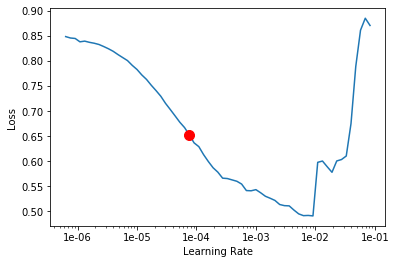

In [53]:
learn_data.recorder.plot(suggestion=True)

In [54]:
learn_data.fit_one_cycle(1, max_lr=3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.081484,0.080063,0.969243,11:20
